In [1]:
import gym
from gym import spaces
from gym.utils import seeding
from tqdm import tqdm

In [2]:
import pandas as pd
import numpy as np
import typing
from datetime import datetime

In [3]:
import ray
# Start up Ray. This must be done before we instantiate any RL agents.
ray.init(num_cpus=20, ignore_reinit_error=True, log_to_driver=False)

2020-12-09 01:27:20,104	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265
2020-12-09 01:27:20,111	WARNING services.py:1560 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.


{'node_ip_address': '172.17.0.2',
 'raylet_ip_address': '172.17.0.2',
 'redis_address': '172.17.0.2:6379',
 'object_store_address': '/tmp/ray/session_2020-12-09_01-27-19_556678_11232/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-12-09_01-27-19_556678_11232/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2020-12-09_01-27-19_556678_11232',
 'metrics_export_port': 54809,
 'node_id': 'b3c1fd63ee35c4182977127bfce002e0f379b506'}

In [4]:

def load_data(
    price_source: str, 
    tickers: typing.List[str],
    start: datetime, 
    end: datetime, 
    features: typing.List[str],
):
    """Returned price data to use in gym environment"""
    # Load data
    # Each dataframe will have columns date and a collection of fields
    # TODO: DataLoader from mongoDB
    # Raw price from DB, forward impute on the trading days for missing date
    # calculate the features (log return, volatility)
    if price_source in ["csvdata"]:
        feature_df = []
        for t in tickers:
            df1 = pd.read_csv("csvdata/{}.csv".format(t))
            df1['datetime'] = pd.to_datetime(df1['datetime'])
            df1 = df1[(df1['datetime']>=start) & (df1['datetime']<=end)]
            df1.set_index("datetime",inplace=True)
            selected_features = ['return','tcost'] + features
            feature_df.append(df1[selected_features])
            ref_df_columns = df1[selected_features].columns

    # assume all the price_df are aligned and cleaned in the DataLoader
    merged_df = pd.concat(feature_df, axis=1, join="outer")
    # Imputer missing values with zeros 
    price_tensor = merged_df['return'].fillna(0.0).values
    tcost = merged_df['tcost'].fillna(0.0).values

    return {
        "dates": merged_df.index,
        "fields": ref_df_columns,
        "data": merged_df.fillna(0.0).values,
        "pricedata": price_tensor,
        "tcost": tcost,
    }


In [5]:
load_data('csvdata',['SPY','QQQ',], datetime(2010, 5, 4), datetime(2020, 12, 31), ["volatility_20", "skewness_20", "kurtosis_20"] ) ['data'][:10,:]

array([[-2.36998991e-02,  4.25369008e-05,  1.09934270e-02,
        -9.14812793e-01, -2.61064489e-01, -3.01849936e-02,
         1.03231135e-04,  1.16465557e-02, -1.10048552e+00,
         5.96949184e-01],
       [-5.94984959e-03,  4.27953952e-05,  1.09991806e-02,
        -9.10788716e-01, -2.70376218e-01, -5.12061786e-03,
         1.03745202e-04,  1.16723407e-02, -9.95452223e-01,
         4.23777969e-01],
       [-3.36369023e-02,  4.42928644e-05,  1.30807177e-02,
        -9.16682320e-01, -2.54900342e-01, -3.36202334e-02,
         0.00000000e+00,  1.37192261e-02, -9.68839072e-01,
        -4.24718444e-02],
       [-1.49229482e-02,  4.49216118e-05,  1.31754036e-02,
        -7.10326792e-01, -5.75516042e-01, -2.49435926e-02,
         0.00000000e+00,  1.45399702e-02, -7.26873145e-01,
        -6.77999658e-01],
       [ 4.29173814e-02,  4.30496362e-05,  1.66156842e-02,
         3.64864054e-01,  7.49281745e-01,  5.01088321e-02,
         1.04701078e-04,  1.85963149e-02,  4.85487538e-01,
         1.

In [6]:
from empyrical import max_drawdown, alpha_beta, sharpe_ratio, annual_return
from sklearn.preprocessing import StandardScaler 

class Equitydaily(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        self.random_start = env_config['random_start']
        self.trading_days = env_config['trading_days'] # Number of days the algorithm runs before resetting
        # Load price data, to be replaced by DataLoader class
        raw_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'],env_config['features'])
        # Set the trading dates, features and price data 
        self.dates = raw_data['dates']
        self.fields = raw_data['fields']
        self.pricedata = raw_data['pricedata']
        self.featuredata = raw_data['data']
        self.tcostdata = raw_data['tcost']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2 
        self.n_assets_fields = len(self.fields)
        self.n_features = self.n_assets_fields * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        #self.n_features = self.n_assets_fields * len(self.tickers)
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        if self.lookback == 1:
            self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.n_features,), dtype=np.float32)
        else:
            self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features,1), dtype=np.float32)

        self.reset()

        

    def step(self, action):
        
        # Trade every 10 days 
        # Normalise action space 
        if (self.index - self.start_index) % 10 == 0:
            normalised_action = action / np.sum(np.abs(action))
            self.actions = normalised_action
        
        done = False
        # Rebalance portfolio at close using return of the next date
        next_day_log_return = self.pricedata[self.index,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(self.actions,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [self.actions], axis=0)
        # Portfolio return 
        today_portfolio_return = np.sum(self.actions[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        recent_series = pd.Series(self.log_return_series)[-100:]
        #print(recent_series)
        rolling_volatility = np.std(recent_series)
        self.metric = today_portfolio_return / rolling_volatility 
        reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.trading_days is None:
            done = self.index >= self.pricedata.shape[0]-2
        else:
            done = (self.index - self.start_index) >= self.trading_days
            
        # Prepare observation for next day
        self.index += 1
        self.observation = self.get_observation()
            
        return self.observation, reward, done, {}
    
    
    def reset(self):
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        self.metric = 0           
        if self.random_start:
            num_days = len(self.dates)      
            self.start_index = np.random.randint(self.lookback, num_days - self.trading_days)
            self.index = self.start_index
        else:
            self.start_index = self.lookback
            self.index = self.lookback
        self.actions = np.zeros(shape=self.n_assets)
        self.observation = self.get_observation()
        return self.observation
    
    def get_observation(self):
        # Can use simple moving average data here 
        last_lookback_day = self.index - self.start_index
        price_lookback = self.featuredata[last_lookback_day:last_lookback_day + self.lookback,:]
        metrics = np.vstack((self.log_return_series[last_lookback_day:last_lookback_day + self.lookback], 
                             self.metric_series[last_lookback_day:last_lookback_day + self.lookback])).transpose()
        positions = self.position_series[last_lookback_day:last_lookback_day + self.lookback]
#        scaler = StandardScaler()
#        price_lookback = scaler.fit_transform(price_lookback)
        observation = np.concatenate((price_lookback, metrics, positions), axis=1)
        if self.lookback == 1:
            return observation.reshape(-1)
        return observation.reshape((observation.shape[0], observation.shape[1], 1))
    
    # 0.05% and spread to model t-cost for institutional portfolios 
    def transaction_cost(self, new_action, old_action):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995 - self.tcostdata[self.index,:]
        fees = np.array(list(fees) + [0.9995])
        tcost = turnover * np.log(fees)
        return tcost 

In [12]:
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

Instructions for updating:
non-resource variables are not supported in the long term


In [13]:
from ray.rllib.models.tf.attention_net import GTrXLNet

config = DEFAULT_CONFIG.copy()
config['num_workers'] = 20
config["num_envs_per_worker"] = 1
config["rollout_fragment_length"] = 760
config["train_batch_size"] = 506*30
config["batch_mode"] = "complete_episodes"
config['num_sgd_iter'] = 20
config['sgd_minibatch_size'] = 3000
config["lr"] =  5e-5
config['lambda'] = 0.9

config['model']['use_lstm'] = True
config['model']['max_seq_len'] = 760
config['model']['lstm_cell_size'] = 30

#config['model']['dim'] = 200
config['model']['conv_filters'] = None #[[32, [5, 1], 5], [32, [5, 1], 5], [4, [5, 1], 5]]
config['num_cpus_per_worker'] = 1  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['env_config'] = {'pricing_source':'csvdata', "tickers": ["BRK_A", "GE_","GOLD_", "AAPL_","GS_","T_",],
          'lookback':1, 'start':'2008-01-02', 'end':'2015-12-31', 'features':["return_volatility_20", "return_skewness_20", "return_kurtosis_20"],
          'random_start': True, 'trading_days': 759}

"""config = DEFAULT_CONFIG.copy()
config["num_workers"] = 20
config["num_envs_per_worker"] = 1
config["rollout_fragment_length"] = 50
config["train_batch_size"] = 25000
config["batch_mode"] = "complete_episodes"
config["num_sgd_iter"] = 20
config["sgd_minibatch_size"] = 2000
config["model"]["dim"] = 200
config["model"]["conv_filters"] = [[16, [5, 1], 5], [16, [5, 1], 5], [16, [5, 1], 5]]
config[
    "num_cpus_per_worker"
] = 1  # This avoids running out of resources in the notebook environment when this cell is re-executed
config["env_config"] = {
    "pricing_source": "csvdata",
    "tickers": [
        "BRK_A", "GE_","GOLD_", "AAPL_","GS_","T_"
    ],
    "lookback": 200,
    "start": "1995-01-02",
    "end": "2015-12-31",
    "features": [
        "return_volatility_20",
        "return_skewness_20",
        "adjvolume_volatility_20",
    ],
    "random_start": True,
    "trading_days": 1000,
}"""

'config = DEFAULT_CONFIG.copy()\nconfig["num_workers"] = 20\nconfig["num_envs_per_worker"] = 1\nconfig["rollout_fragment_length"] = 50\nconfig["train_batch_size"] = 25000\nconfig["batch_mode"] = "complete_episodes"\nconfig["num_sgd_iter"] = 20\nconfig["sgd_minibatch_size"] = 2000\nconfig["model"]["dim"] = 200\nconfig["model"]["conv_filters"] = [[16, [5, 1], 5], [16, [5, 1], 5], [16, [5, 1], 5]]\nconfig[\n    "num_cpus_per_worker"\n] = 1  # This avoids running out of resources in the notebook environment when this cell is re-executed\nconfig["env_config"] = {\n    "pricing_source": "csvdata",\n    "tickers": [\n        "BRK_A", "GE_","GOLD_", "AAPL_","GS_","T_"\n    ],\n    "lookback": 200,\n    "start": "1995-01-02",\n    "end": "2015-12-31",\n    "features": [\n        "return_volatility_20",\n        "return_skewness_20",\n        "adjvolume_volatility_20",\n    ],\n    "random_start": True,\n    "trading_days": 1000,\n}'

In [14]:
config

{'num_workers': 20,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 760,
 'batch_mode': 'complete_episodes',
 'num_gpus': 0,
 'train_batch_size': 15180,
 'model': {'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': True,
  'max_seq_len': 760,
  'lstm_cell_size': 30,
  'lstm_use_prev_action_reward': False,
  '_time_major': False,
  'framestack': True,
  'dim': 84,
  'grayscale': False,
  'zero_mean': True,
  'custom_model': None,
  'custom_model_config': {},
  'custom_action_dist': None,
  'custom_preprocessor': None},
 'optimizer': {},
 'gamma': 0.99,
 'horizon': None,
 'soft_horizon': False,
 'no_done_at_end': False,
 'env_config': {'pricing_source': 'csvdata',
  'tickers': ['BRK_A', 'GE_', 'GOLD_', 'AAPL_', 'GS_', 'T_'],
  'lookback': 1,
  'start': '2008-01-02',
  'end': '2015-12-31',
  'featu

Check to see if agents can be trained

In [15]:
ray.shutdown()
ray.init(num_cpus=20, ignore_reinit_error=True, log_to_driver=False)

2020-12-09 01:27:34,869	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265
2020-12-09 01:27:34,875	WARNING services.py:1560 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.


{'node_ip_address': '172.17.0.2',
 'raylet_ip_address': '172.17.0.2',
 'redis_address': '172.17.0.2:6379',
 'object_store_address': '/tmp/ray/session_2020-12-09_01-27-34_319763_11232/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-12-09_01-27-34_319763_11232/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2020-12-09_01-27-34_319763_11232',
 'metrics_export_port': 60424,
 'node_id': 'd23fb2c853602442353b8300aa5e32ca51583164'}

In [16]:
agent = PPOTrainer(config, Equitydaily)
best_reward = -np.inf

2020-12-09 01:27:35,426	ERROR syncer.py:63 -- Log sync requires rsync to be installed.
2020-12-09 01:27:35,430	INFO trainer.py:592 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2020-12-09 01:27:35,431	INFO trainer.py:1065 -- `_use_trajectory_view_api` only supported for PyTorch so far! Will run w/o.
2020-12-09 01:27:35,433	INFO trainer.py:619 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_in (InputLayer)             [(None,)]            0                                            
__________________________________________________________________________________________________
tf_op_layer_default_policy/Sequ [()]                 0           seq_in[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_default_policy/Sequ [()]                 0           tf_op_layer_default_policy/Sequen
__________________________________________________________________________________________________
tf_op_layer_default_policy/Sequ [(None, 1)]          0           seq_in[0][0]                     
_______________________________________________________________________________________

2020-12-09 01:27:44,004	WARNING util.py:40 -- Install gputil for GPU system monitoring.


In [17]:
episodes = 3500
ep_total = 0
#ep_per_iter = config['train_batch_size']*config['sgd_minibatch_size']/config['env_config']['trading_days']
#for i in tqdm(range(int(episodes/ep_per_iter))):
while ep_total < episodes:
    result = agent.train()
    ep_total = result['episodes_total']
    print(ep_total)
    if result['episode_reward_mean'] > best_reward:
        #path = agent.save('sampleagent')
        #print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.
20
-11.372250392943666
40
-6.61171448372655
100
120
140
160
180
200
220
240
260
280
300
320
340
360
-5.976758708591645
380
-4.577359684621901
400
-3.274960741249105
420
440
-3.044778818512877
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
-1.6115394548015722
760
0.11205533802706423
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
0.24053921248397017
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
0.7298041955802944
2420
3.7493850706934717
2440
3.8089587222058
2460
2480
2500
2520
2540
4.1142840684785575
2560
4.513262132666821
2580
5.695837650240402
2600
6.38924908170306
2620
2640
2660
2680
2

100


<AxesSubplot:>

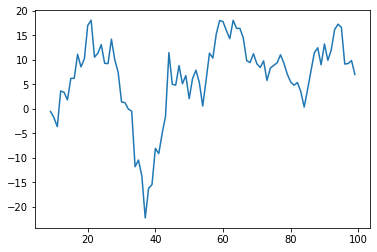

In [18]:
print(len(result['hist_stats']['episode_reward']))
pd.Series(result['hist_stats']['episode_reward']).rolling(window=10).mean().plot()

1.3642190582432305

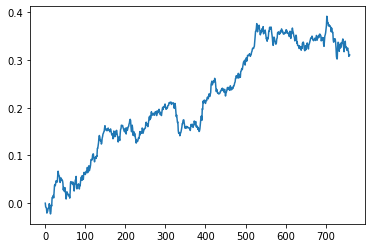

In [19]:
env = Equitydaily(config['env_config'])
state = env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()
rnn_state = [np.zeros((30)),
             np.zeros((30))]
while not done:
    action, rnn_state, _ = agent.compute_action(state, rnn_state, explore=False)
    #action = np.array([0,0,0,0,0,0,1])
    #action = agent.compute_action(state)
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(env.log_return_series).cumsum().plot()
np.exp(pd.Series(env.log_return_series).cumsum().iloc[-1])

100%|██████████| 100/100 [02:20<00:00,  1.40s/it]


1.035518012062937

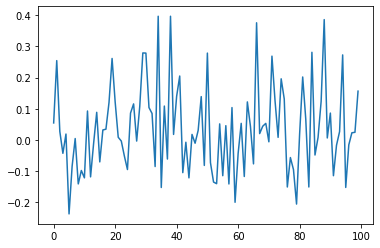

In [20]:
eval_env_config = {'pricing_source':'csvdata', "tickers": ["BRK_A", "GE_","GOLD_", "AAPL_","GS_","T_",],
          'lookback':1, 'start':'2016-01-01', 'end':'2019-12-31', 'features':["return_volatility_20", "return_skewness_20", "return_kurtosis_20"],
          'random_start': True, 'trading_days': 759}

env = Equitydaily(eval_env_config)
last_log_returns = []
for i in tqdm(range(100)):
    state = env.reset()
    done = False
    reward_list = []
    cum_reward = 0
    actions = list()
    rnn_state = [np.zeros((30)),
                 np.zeros((30))]
    while not done:
        action, rnn_state, _ = agent.compute_action(state, rnn_state, explore=False)
        #action = np.array([0,0,0,0,0,0,1])
        #action = agent.compute_action(state)
        state, reward, done, _ = env.step(action)
        cum_reward += reward
        actions.append(action)
        reward_list.append(reward)
    
    last_log_returns.append(pd.Series(env.log_return_series).cumsum().iloc[-1])
pd.Series(last_log_returns).plot()
np.exp(np.mean(last_log_returns))

100%|██████████| 100/100 [00:28<00:00,  3.46it/s]


1.0731393086982977

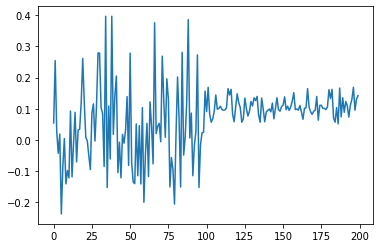

In [21]:
for i in tqdm(range(100)):
    env.reset()
    done = False
    reward_list = []
    cum_reward = 0
    actions = list()
    rnn_state = [np.zeros((30)),
                 np.zeros((30))]
    while not done:
        action = np.array([1,1,1,1,1,1,1])/7
        _, reward, done, _ = env.step(action)
        cum_reward += reward
        actions.append(action)
        reward_list.append(reward)
    
    last_log_returns.append(pd.Series(env.log_return_series).cumsum().iloc[-1])
pd.Series(last_log_returns).plot()
np.exp(np.mean(last_log_returns))

In [22]:
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 20
config["num_envs_per_worker"] = 1
config["rollout_fragment_length"] = 760
config["train_batch_size"] = 506*30
config["batch_mode"] = "complete_episodes"
config['num_sgd_iter'] = 20
config['sgd_minibatch_size'] = 3000
config["lr"] = 5e-5
config['lambda'] = 0.9

config['model']['use_lstm'] = False
config['model']['max_seq_len'] = 760
config['model']['lstm_cell_size'] = 30

config["model"]["dim"] = 200
config["model"]["conv_filters"] = [[16, [5, 1], 5], [16, [5, 1], 5], [16, [5, 1], 5]]

config['num_cpus_per_worker'] = 1  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['env_config'] = {'pricing_source':'csvdata', "tickers": ["BRK_A", "GE_","GOLD_", "AAPL_","GS_","T_",],
          'lookback': 200, 'start':'2008-01-02', 'end':'2015-12-31', 'features':["return_volatility_20", "return_skewness_20", "return_kurtosis_20"],
          'random_start': True, 'trading_days': 759}
config

{'num_workers': 20,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 760,
 'batch_mode': 'complete_episodes',
 'num_gpus': 0,
 'train_batch_size': 15180,
 'model': {'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': [[16, [5, 1], 5], [16, [5, 1], 5], [16, [5, 1], 5]],
  'conv_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 760,
  'lstm_cell_size': 30,
  'lstm_use_prev_action_reward': False,
  '_time_major': False,
  'framestack': True,
  'dim': 200,
  'grayscale': False,
  'zero_mean': True,
  'custom_model': None,
  'custom_model_config': {},
  'custom_action_dist': None,
  'custom_preprocessor': None},
 'optimizer': {},
 'gamma': 0.99,
 'horizon': None,
 'soft_horizon': False,
 'no_done_at_end': False,
 'env_config': {'pricing_source': 'csvdata',
  'tickers': ['BRK_A', 'GE_', 'GOLD_', 'AAPL_', 'GS_', 'T_'],
  'lookback': 200,
  'st

In [23]:
ray.shutdown()
ray.init(num_cpus=20, ignore_reinit_error=True, log_to_driver=False)

2020-12-09 03:38:29,922	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265
2020-12-09 03:38:29,927	WARNING services.py:1560 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67092480 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.


{'node_ip_address': '172.17.0.2',
 'raylet_ip_address': '172.17.0.2',
 'redis_address': '172.17.0.2:6379',
 'object_store_address': '/tmp/ray/session_2020-12-09_03-38-29_300300_11232/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-12-09_03-38-29_300300_11232/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2020-12-09_03-38-29_300300_11232',
 'metrics_export_port': 46992,
 'node_id': '6b0503987e7a00dfa4b90382b289dbc2e8c07e4f'}

In [24]:
agent = PPOTrainer(config, Equitydaily)
best_reward = -np.inf

2020-12-09 03:38:36,712	WARNING util.py:40 -- Install gputil for GPU system monitoring.


In [25]:
episodes = 3500
ep_total = 0
#ep_per_iter = config['train_batch_size']*config['sgd_minibatch_size']/config['env_config']['trading_days']
#for i in tqdm(range(int(episodes/ep_per_iter))):
while ep_total < episodes:
    result = agent.train()
    ep_total = result['episodes_total']
    print(ep_total)
    if result['episode_reward_mean'] > best_reward:
        #path = agent.save('sampleagent')
        #print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

20
-13.176841012111987
40
60
80
100
120
140
160
180
200
220
240
260
-11.471914434785413
280
300
320
340
-10.7923011159522
360
-7.7370268791296
380
-5.331692882535578
400
-1.3421593346441378
420
440
-1.2342496420459492
460
480
500
520
540
560
580
600
-0.5524022139343766
620
640
0.056652560525448
660
2.9923144984261096
680
4.938332883638207
700
5.550117665839366
720
10.076645336572303
740
12.347483131381404
760
13.947696578206953
780
800
17.418528498884967
820
840
860
880
900
920
17.451875582110212
940
17.495382045994013
960
21.808202425138813
980
25.25231428211137
1000
28.640213603647616
1020
29.714316057167444
1040
31.378275236910962
1060
33.47214419964393
1080
1100
1120
34.22226756003048
1140
37.16532797823002
1160
1180
41.32470945869783
1200
1220
1240
1260
1280
1300
45.60733126060554
1320
1340
48.02621975974768
1360
48.203965958679554
1380
49.254455239531374
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
49.48635430724527
1640
51.92351077533972
1660
53.76250356634314
168

1.6452648122783138

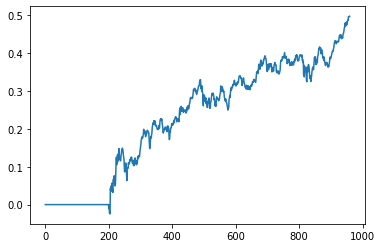

In [28]:
env = Equitydaily(config['env_config'])
state = env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()
while not done:
    #action, rnn_state, _ = agent.compute_action(state, rnn_state, explore=False)
    #action = np.array([0,0,0,0,0,0,1])
    action = agent.compute_action(state, explore=False)
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(env.log_return_series).cumsum().plot()
np.exp(pd.Series(env.log_return_series).cumsum().iloc[-1])

100%|██████████| 100/100 [05:53<00:00,  3.54s/it]


1.213540889778119

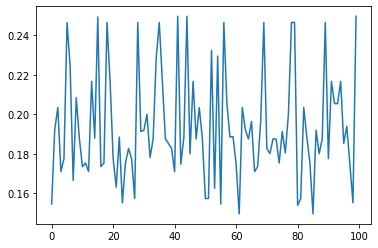

In [33]:
eval_env_config = {'pricing_source':'csvdata', "tickers": ["BRK_A", "GE_","GOLD_", "AAPL_","GS_","T_",],
          'lookback':200, 'start':'2016-01-01', 'end':'2019-12-31', 'features':["return_volatility_20", "return_skewness_20", "return_kurtosis_20"],
          'random_start': True, 'trading_days': 759}

env = Equitydaily(eval_env_config)
last_log_returns = []
for i in tqdm(range(100)):
    state = env.reset()
    done = False
    reward_list = []
    cum_reward = 0
    actions = list()
    while not done:
        action = agent.compute_action(state, explore=False)
        state, reward, done, _ = env.step(action)
        cum_reward += reward
        actions.append(action)
        reward_list.append(reward)
    
    last_log_returns.append(pd.Series(env.log_return_series).cumsum().iloc[-1])
pd.Series(last_log_returns).plot()
np.exp(np.mean(last_log_returns))

100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


1.1819014304476607

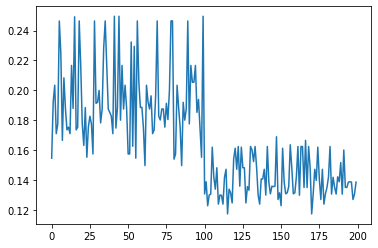

In [34]:
for i in tqdm(range(100)):
    env.reset()
    done = False
    reward_list = []
    cum_reward = 0
    actions = list()
    while not done:
        action = np.array([1,1,1,1,1,1,1])/7
        _, reward, done, _ = env.step(action)
        cum_reward += reward
        actions.append(action)
        reward_list.append(reward)
    
    last_log_returns.append(pd.Series(env.log_return_series).cumsum().iloc[-1])
pd.Series(last_log_returns).plot()
np.exp(np.mean(last_log_returns))